# **Project 1**

---

**Simple Art Restoration with U-Net**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

In [ ]:
# Step 1: Define a Tiny U-Net

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3): # [64, 64, 3]
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64) # [64, 64, 64]
        self.pool1 = nn.MaxPool2d(2) # [32, 32, 64]
        self.down2 = DoubleConv(64, 128) # [32, 32, 128]
        self.pool2 = nn.MaxPool2d(2) # [16, 16, 128]

        self.bottleneck = DoubleConv(128, 256) # [16, 16, 256]

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2) # [32, 32, 128 + 128]
        self.dec2 = DoubleConv(256, 128) # [32, 32, 128]
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2) # [64, 64, 64 + 64]
        self.dec1 = DoubleConv(128, 64) # [64, 64, 64]

        self.final = nn.Conv2d(64, out_channels, 1) # [64, 64, 3]

    def forward(self, x):
        # Encoder: downsampling path (extract features, lose some detail)
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        # Bottleneck: compressed global representation
        bn = self.bottleneck(p2)

        # Decoder: upsampling path (reconstruct image)
        u2 = self.up2(bn)
        cat2 = torch.cat([u2, d2], dim=1)  # Skip Connection: bring back mid-level details
        d2 = self.dec2(cat2)

        u1 = self.up1(d2)
        cat1 = torch.cat([u1, d1], dim=1)  # Skip Connection: bring back fine details (edges, brushstrokes)
        d1 = self.dec1(cat1)

        return self.final(d1)  # Output: restored image

In [ ]:
# Step 2: Prepare the Dataset

class DamagedDataset(Dataset):
    def __init__(self, train=True):
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])
        self.data = datasets.CIFAR10(root="./data", train=train,
                                     transform=transform, download=True)

    def add_damage(self, img):
        img = img.clone()
        mask = torch.zeros_like(img)

        C, H, W = img.shape

        # Block damage
        if random.random() > 0.5:
            block_size = random.randint(12, 24)
            x = random.randint(0, W - block_size)
            y = random.randint(0, H - block_size)
            img[:, y:y+block_size, x:x+block_size] = 0
            img[0, y:y+block_size, x:x+block_size] = 1
            img[1, y:y+block_size, x:x+block_size] = 0
            img[2, y:y+block_size, x:x+block_size] = 0
            mask[:, y:y+block_size, x:x+block_size] = 1

        # Streaks / scratches
        if random.random() > 0.5:
            num_streaks = random.randint(3, 7)
            for _ in range(num_streaks):
                x1, y1 = random.randint(0, W-1), random.randint(0, H-1)
                length = random.randint(10, 30)
                angle = random.uniform(-0.5, 0.5)
                for i in range(length):
                    xi = int(x1 + i)
                    yi = int(y1 + i*angle)
                    if 0 <= xi < W and 0 <= yi < H:
                        img[:, yi, xi] = 0
                        img[0, yi, xi] = 1
                        img[1, yi, xi] = 0
                        img[2, yi, xi] = 0
                        mask[:, yi, xi] = 1
        return img, mask

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        clean, _ = self.data[idx]
        damaged, mask = self.add_damage(clean)
        return damaged, clean, mask

train_dataset = DamagedDataset(train=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:06<00:00, 27.8MB/s]


In [ ]:
# Step 3: Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training started...")
for epoch in range(3):
    for damaged, clean, mask in train_loader:
        damaged, clean = damaged.to(device), clean.to(device)
        output = model(damaged)
        loss = criterion(output, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Training started...
Epoch 1: Loss = 0.0004
Epoch 2: Loss = 0.0005
Epoch 3: Loss = 0.0006


In [ ]:
# Helper to add black border
def add_black_border(img_tensor, border=1):
    bordered = img_tensor.clone()
    C, H, W = bordered.shape

    # Top and bottom
    bordered[:, :border, :] = 0
    bordered[:, H-border:, :] = 0

    # Left and right
    bordered[:, :, :border] = 0
    bordered[:, :, W-border:] = 0

    return bordered

# Step 4: Visualization

def show_images(damaged, restored, clean, masks, n_samples=3):
    stages = ['Damaged', 'AI Patch', 'Restored', 'Original']
    plt.figure(figsize=(10, 2 * n_samples), facecolor='white')

    for i in range(n_samples):
        # Damaged input
        img = add_black_border(damaged[i].cpu(), border=1)
        img = torch.clamp(img, 0, 1).float()
        plt.subplot(n_samples, 4, i*4 + 1)
        ax = plt.gca()
        ax.set_facecolor('white')
        plt.imshow(np.transpose(img.numpy(), (1,2,0)), origin='upper')
        if i == 0:
            plt.title("Damaged")
        plt.axis('off')

        # AI Patch (true restored colors)
        canvas = torch.ones_like(restored[i].cpu())
        canvas = canvas * (1 - masks[i].cpu()) + restored[i].detach().cpu() * masks[i].cpu()
        canvas = torch.clamp(canvas, 0, 1)
        canvas = add_black_border(canvas, border=1)

        plt.subplot(n_samples, 4, i*4 + 2)
        ax = plt.gca()
        ax.set_facecolor('white')
        plt.imshow(np.transpose(canvas.numpy(), (1,2,0)), origin='upper')
        if i == 0:
            plt.title("AI Patch")
        plt.axis('off')

        # Restored output
        img = add_black_border(restored[i].detach().cpu(), border=1)
        img = torch.clamp(img, 0, 1).float()
        plt.subplot(n_samples, 4, i*4 + 3)
        ax = plt.gca()
        ax.set_facecolor('white')
        plt.imshow(np.transpose(img.numpy(), (1,2,0)), origin='upper')
        if i == 0:
            plt.title("Restored")
        plt.axis('off')

        # Original ground truth
        img = add_black_border(clean[i].cpu(), border=1)
        img = torch.clamp(img, 0, 1).float()
        plt.subplot(n_samples, 4, i*4 + 4)
        ax = plt.gca()
        ax.set_facecolor('white')
        plt.imshow(np.transpose(img.numpy(), (1,2,0)), origin='upper')
        if i == 0:
            plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

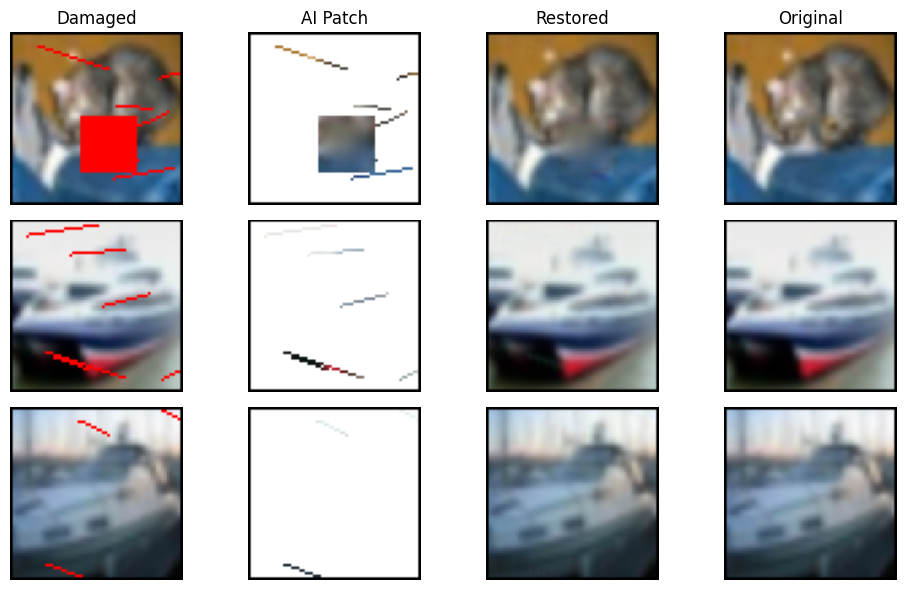

In [ ]:
# Test on a few samples
test_dataset = DamagedDataset(train=False)
damaged, clean, masks = zip(*[test_dataset[i] for i in range(5)])
damaged = torch.stack(damaged).to(device)
clean = torch.stack(clean).to(device)
masks = torch.stack(masks)

restored = model(damaged)

show_images(damaged, restored, clean, masks)

[Download the Report (PDF)](report.pdf)